# 1 - Introduction

### What is OSMnx?

> A __Python package__ to download administrative boundary shapes and street networks from OSM.
>It is built over 
>###  *Networkx     +     Geopandas     +     Matplotlib*
>allowing for basic and extended __spatial statistical analysis and visualization__

>### *R-tree*
>allowing __fast__ spatial queries

### And what makes it special?

> __Automated downloading__ of boundary shapes, streets and building footprint

> Ability to extract it in __3 different formats__

### Cool! Let's see it in action ..

In [1]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import IFrame
from shapely.geometry import Point
from descartes import PolygonPatch
import folium

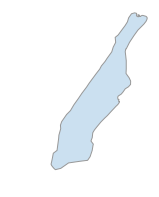

In [2]:
# get the boundary polygon for manhattan, save it as a shapefile, project it to UTM, and plot it
city = ox.gdf_from_place('Manhattan, New York City, New York, USA')
ox.save_gdf_shapefile(city)
fig, ax = ox.plot_shape(city, figsize=(3,3))

### This could be a county, city, state, country, continent or even a list of multiple places

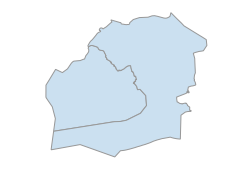

In [5]:
place_names = ['Brooklyn, New York City, New York, USA', 'Queens, New York City, New York, USA']
nyc = ox.gdf_from_places(place_names)
fig, ax = ox.plot_shape(nyc, figsize=(3,3))

### Moving to streets..


Street networks can be downloaded by providing either
* A bounding box
* A lat-lon with distance
* Name(s) of place
* Address of place with distance
* Polygon for streets within

Street networks can be filtered for the following types
* 'drive'
* 'service'
* 'bike'
* 'walk'
* 'all' - default
* 'all_private'

#### A graph of street network for Manhattan

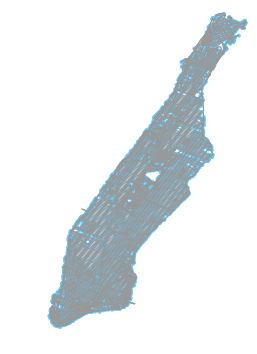

(<matplotlib.figure.Figure at 0x1bd26128>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1bd267b8>)

In [31]:
G1 = ox.graph_from_place('Manhattan, USA')
ox.plot_graph(G1)

#### A graph for driveable streets within a 1000 m radius around Carto (by Address)

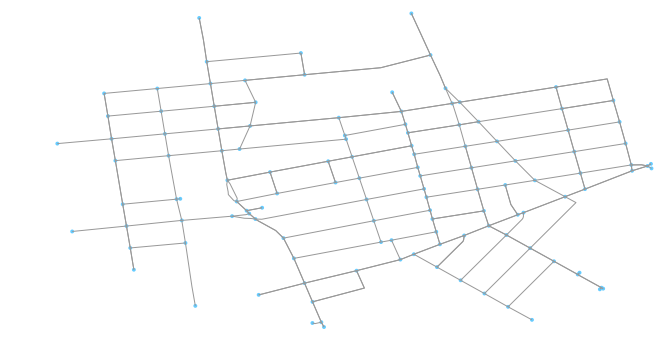

(<matplotlib.figure.Figure at 0x7fe4362ba590>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe432e39ed0>)

In [10]:
G2 = ox.graph_from_address('201 Moore St, Brooklyn, NY', distance=1000, distance_type='network', network_type='drive')
ox.plot_graph(G2)

#### A graph for streets within a 1000 m radius around Carto (by lat lon)

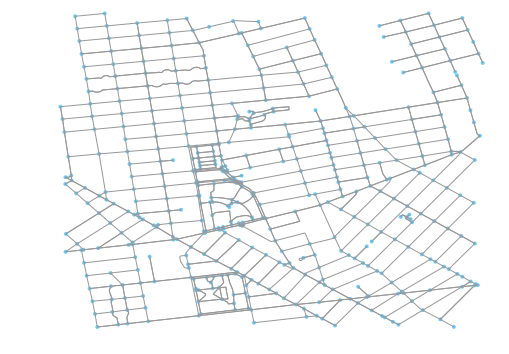

(<matplotlib.figure.Figure at 0x7fe445a60190>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe433349250>)

In [12]:
G3 = ox.graph_from_point((40.704667, -73.936701), distance=1000)
ox.plot_graph(G3)

### Can I save these graphs for later use?

There are 3 different file formats to save these graphs
* Shapefile
* GraphML file (to use in Gephi or NetworkX)
* SVG (to use in Illustrator)

# 2 - Examples
> ### *A. Basic spatial analysis*
> ### *B. Finding shortest distance from Penn station to Grand Central*
> ### *C. How far can I walk in 5, 10, 15 minutes from Penn Station?*
> ### *D. Extracting data ready for eternal use*

## *A. Basic Spatial Analysis*

### Categorizing streets around Carto based on street length

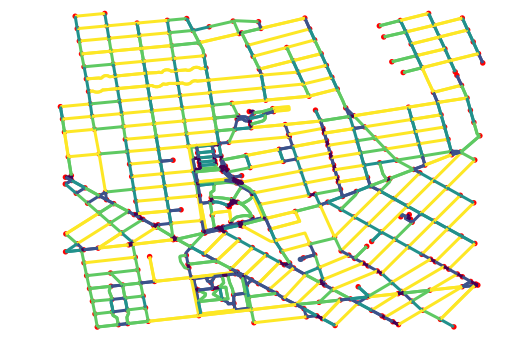

(<matplotlib.figure.Figure at 0x7fe436a4a510>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe431dbd190>)

In [18]:
color = ox.get_edge_colors_by_attr(G3, attr='length')
ox.plot_graph(G3, edge_color=color, node_color='r', node_size=30, edge_linewidth=3)

### Identifying streets as unidirectional or bidirectional

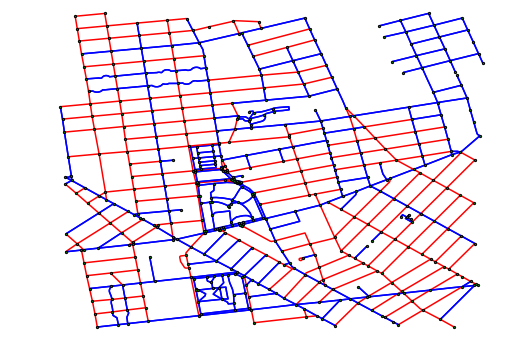

In [21]:
color = ['r' if data['oneway'] else 'b' for u, v, key, data in G3.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G3, node_color='g', node_edgecolor='k', node_size=5, node_zorder=3, 
                           edge_color=color, edge_linewidth=1.5)

### Sneak peek into Street Network Statistics ..

In [33]:
stats = ox.basic_stats(G1)
stats['circuity_avg']

1.03687902784941

Im Manhattan the streets are 3.68% more circuitous than the straight line paths

In [6]:
# get the street network for a place, and its area in square meters
gdf = ox.gdf_from_place('Manhattan, USA')
area = ox.project_gdf(gdf).unary_union.area
G1 = ox.graph_from_place('Manhattan, USA', network_type='drive_service')

In [7]:
# calculate basic and extended network stats, merge them together, and display
stats = ox.basic_stats(G1, area=area)
extended_stats = ox.extended_stats(G1, ecc=True, bc=True, cc=True)
for key, value in extended_stats.items():
    stats[key] = value
pd.Series(stats)

avg_neighbor_degree                    {1773060097: 2.0, 1773060099: 3.0, 373268484: ...
avg_neighbor_degree_avg                                                          2.20555
avg_weighted_neighbor_degree           {1773060097: 0.0636820131315, 1773060099: 0.08...
avg_weighted_neighbor_degree_avg                                               0.0286386
betweenness_centrality                 {1773060097: 0.00382707245182, 1773060099: 0.0...
betweenness_centrality_avg                                                    0.00900715
center                                                                        [42431067]
circuity_avg                                                                      1.0246
closeness_centrality                   {1773060097: 0.000130221252734, 1773060099: 0....
closeness_centrality_avg                                                     0.000142139
clustering_coefficient                 {1773060097: 0.2, 1773060099: 0.0, 373268484: ...
clustering_coefficien

## *B. Finding shortest distance from Penn station to Grand Central*

In [32]:
#Provide coordinates and extract nodes
penn_station = (40.750551, -73.993538)
grand_central = (40.752954, -73.977251)
origin_node = ox.get_nearest_node(G1, penn_station)
destination_node = ox.get_nearest_node(G1, grand_central)
origin_node, destination_node

(3799564971L, 4676427160L)

In [33]:
# find the shortest path between origin and destination nodes
route = nx.shortest_path(G1, origin_node, destination_node, weight='length')

In [34]:
# plot the route with folium
route_map = ox.plot_route_folium(G1, route)

In [37]:
# save as html file then display map as an iframe
filepath = 'osmnx_outputFiles/ManhattanRoute.html'
route_map.save(filepath)
IFrame(filepath, width=600, height=500)

## *C. How far can I walk in 5, 10, 15 minutes from Penn Station?*

In [16]:
#setting basic configuration
network_type = 'walk'
trip_times = [5, 10, 15] #in minutes
travel_speed = 4.5 #walking speed in km/hour

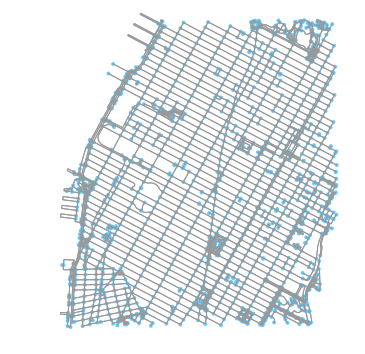

(<matplotlib.figure.Figure at 0x18ff0c18>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10bc1160>)

In [7]:
#Generating graph for a 2km radius around Penn Station
G4 = ox.graph_from_point(penn_station, distance=2000, network_type='walk')
G4 = ox.project_graph(G4)
ox.plot_graph(G4)

In [17]:
# get one color for each isochrone
iso_colors = ox.get_colors(n=len(trip_times), cmap='Blues', start=0.3, return_hex=True)

In [18]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G4.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [19]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G4, 42435642, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

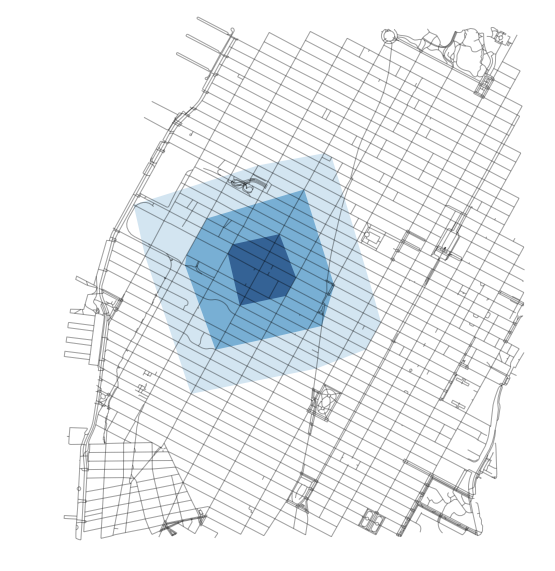

In [20]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G4, fig_height=10, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

## *D. Extracting data for external use*

In [21]:
#Save the graph as a shapefile

ox.save_graph_shapefile(G4, filename='penn_osmnx')

In [22]:
#Read in the the streets as a shapefile

streets_penn = gpd.read_file('data/penn_osmnx/edges/edges.shp')
streets_penn.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6591 entries, 0 to 6590
Data columns (total 18 columns):
access      108 non-null object
bridge      86 non-null object
from        6591 non-null object
geometry    6591 non-null object
highway     6591 non-null object
key         6591 non-null object
lanes       657 non-null object
length      6591 non-null object
maxspeed    2562 non-null object
name        4963 non-null object
oneway      6591 non-null object
osmid       6591 non-null object
ref         255 non-null object
service     99 non-null object
time        6591 non-null object
to          6591 non-null object
tunnel      51 non-null object
width       77 non-null object
dtypes: object(18)
memory usage: 926.9+ KB


In [23]:
streets_penn.head()

,access,bridge,from,geometry,highway,key,lanes,length,maxspeed,name,oneway,osmid,ref,service,time,to,tunnel,width
0,None,None,2631319571,LINESTRING (584460.9542094509 4511068.45276099...,residential,0,None,138.402183643,25 mph,West 24th Street,False,396444294,None,None,1.84536244857,42427427,None,None
1,None,None,2631319571,LINESTRING (584460.9542094509 4511068.45276099...,footway,0,None,118.467445471,None,None,False,257644120,None,None,1.57956593961,2631319579,None,None
2,None,None,2631319571,LINESTRING (584460.9542094509 4511068.45276099...,residential,0,None,156.076307371,25 mph,West 24th Street,False,396444294,None,None,2.08101743162,42427477,None,None
3,None,None,42440323,LINESTRING (585549.5849213719 4510331.78734745...,residential,0,None,12.381342056,25 mph,East 22nd Street,False,456308943,None,None,0.165084560746,4597668040,None,None
4,None,None,4597668040,LINESTRING (585549.5849213719 4510331.78734745...,residential,1,None,12.381342056,25 mph,East 22nd Street,False,456308943,None,None,0.165084560746,42440323,None,None


In [24]:
nodes_penn = gpd.read_file('data/penn_osmnx/nodes/nodes.shp')
nodes_penn.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2431 entries, 0 to 2430
Data columns (total 6 columns):
geometry    2431 non-null object
highway     1056 non-null object
lat         2431 non-null object
lon         2431 non-null object
osmid       2431 non-null object
ref         3 non-null object
dtypes: object(6)
memory usage: 114.0+ KB


In [25]:
nodes_penn.head()

,geometry,highway,lat,lon,osmid,ref
0,POINT (584785.8660343011 4509586.039949605),traffic_signals,40.732847,-73.995914,42421877,None
1,POINT (584522.4160596811 4509727.381590451),None,40.7341472,-73.9990144,42421882,None
2,POINT (584507.7738950988 4509725.749180152),traffic_signals,40.734134,-73.999188,42421889,None
3,POINT (583795.6117145835 4511280.809988485),traffic_signals,40.7482137,-74.0074126,42422258,None
4,POINT (586525.5533276416 4510177.626785028),None,40.7379945,-73.9752329,42422830,None


In [29]:
street = streets_penn.to_json()
node = nodes_penn.to_json()

In [30]:
with open('streets_penn.json', 'w') as f:
    f.write(street)
    
with open('node_penn.json', 'w') as f:
    f.write(node)

### The extracted files can then be plotted using Carto or D3 or any other supported tool